In [ ]:
##!/usr/bin/env python
"""plot_contour.py

Script plots the contour map of various variables for the nested domains:
d02: 800m resolution with urban LCZs

Author: Annette L Hirsch @ CLEX, UNSW. Sydney (Australia)
email: a.hirsch@unsw.edu.au
Created: Tue Sep  1 14:37:33 AEST 2020

"""

In [1]:
import warnings
warnings.filterwarnings("ignore")

Load Packages

In [2]:
#from __future__ import division
import numpy as np
import pandas as pd
import math
import netCDF4 as nc
import sys
import os
import glob as glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
from matplotlib import cm
from matplotlib.collections import LineCollection
import common_functions as cf
import datetime as dt
import wrf
from scipy import stats
import metpy.calc as mpcalc

### Experimental Details of the Model Data

In [3]:
# Simulation Period
syear = 2017
smon = 1
sday = 2 
eyear = 2017
emon = 2
eday = 28  # Add an extra day so that the 27th Feb data is included
simlen = dt.datetime(eyear,emon,eday) - dt.datetime(syear,smon,sday)
nst = (simlen.days * 24 * 6) # No. simulations days x 24 hours in a day x 6 history intervals per hour

# Dates - Used for subsetting the AWS data so you pick the day before the start date and the day after the end date
sdate = "2017-01-01"
edate = "2017-02-28"

# Data directory 
datadir='/g/data/w97/azh561/WRF/'
ensmem = ['sydney800m','sydney800m_06H','sydney800m_12H','sydney800m_18H','sydney800m_00H'] 
rlabels = ['U1','U2','U3','U4','U5']
domain = ["d02","d02","d02","d02","d02"]
nmem = len(ensmem)

# Landsea mask
mask_file='/g/data/w97/azh561/WRF/sydney800m/geo_em.%s.nc' %(domain[0])
f = nc.Dataset(mask_file)
lu = f.variables['LU_INDEX'][0,:,:]
luf = f.variables['LANDUSEF'][0,:,:,:]
lat2d = f.variables['XLAT_M'][0,:,:]
lontmp = f.variables['XLONG_M'][0,:,:]
lon2d = np.where(lontmp<0.0,lontmp+360,lontmp)
hgt2d = f.variables['HGT_M'][0,:,:]
lsmask = f.variables['LANDMASK'][0,:,:]
clon = f.getncattr('CEN_LON')
nlu = f.getncattr('NUM_LAND_CAT')
iswater = f.getncattr('ISWATER')
nlat,nlon = lon2d.shape
f.close()

lat1d = lat2d[:,0]
lon1d = lon2d[0,:]

# Use helper function defined above to calculate distance
# between lat/lon grid points
dx, dy = mpcalc.lat_lon_grid_deltas(lon1d, lat1d)


In [4]:
start = dt.datetime(syear,smon,sday,0,0,0)
end = dt.datetime(eyear,emon,eday,0,0,0)
days = (end - start).days
ntim = days * 24 * 60
datelist = [start + dt.timedelta(minutes=x) for x in range(ntim+1)]
# Get the day-month hour-minutes on 10 minute interval
ftimes = np.asarray([datelist[x].strftime("%m-%d %H-%M") for x in range(ntim+1)])[::10]
fhours = np.asarray([datelist[x].strftime("%H") for x in range(ntim+1)])[::10]

### Split analysis by heatwave periods

From the Bureau of Meteorology Special Climate Statement 61 there were 3 heatwaves:

    10-14 January
    17-21 January
    31 January - 12 February 
    
For the latter heatwave this was terminated by a cold front.

So here we examine separately the week before the first heatwave, each heatwave period and the week after the third heatwave

If using the Sydney Airport Data as well as Richmond and Observatory Hill (via Scorcher) the dates for the heatwaves are:

    11-14 January
    16-18 January
    30 January - 1 February
    5-7 February
    10-12 February

In [5]:
HW1S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-11 00-00']][0]
HW1F = [i for i in range(len(ftimes)) if ftimes[i] in ['01-14 12-00']][0]

HW2S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-16 00-00']][0]
HW2F = [i for i in range(len(ftimes)) if ftimes[i] in ['01-18 12-00']][0]

HW3S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-30 00-00']][0]
HW3F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-01 12-00']][0]

HW4S = [i for i in range(len(ftimes)) if ftimes[i] in ['02-05 00-00']][0]
HW4F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-07 12-00']][0]

HW5S = [i for i in range(len(ftimes)) if ftimes[i] in ['02-10 00-00']][0]
HW5F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-12 12-00']][0]


### Extract model data corresponding to the first 3 hours of the first heatwave day

In [6]:
hwdates = ['01-11','01-16','01-30','02-05','02-10']
nhw = len(hwdates)

In [7]:
t2 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
q2 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
psfc = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
wspd = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
u10 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
v10 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
o850 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
u850 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
v850 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
w850 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
div = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)

for hh in range(nhw):
    for mm in range(nmem):
        
        # Files list
        fileprefix = '%s/%s/WRF_output/%s/wrfout_%s_2017-' %(datadir,ensmem[mm],domain[mm],domain[mm])
        filelist = sorted(glob.glob('%s%s_0[0-2]*' %(fileprefix,hwdates[hh])))

        wrffiles = [nc.Dataset(filelist[0]),nc.Dataset(filelist[1]),nc.Dataset(filelist[2])]
        
        t2tmp = wrf.getvar(wrffiles,'T2',timeidx=None,method='cat')[:,:,:] - 273.15 # to degC
        q2tmp = wrf.getvar(wrffiles,'Q2',timeidx=None,method='cat')[:,:,:]
        ptmp = wrf.getvar(wrffiles,'PSFC',timeidx=None,method='cat')[:,:,:] /100. # to hPa
        utmp = wrf.getvar(wrffiles,'U10',timeidx=None,method='cat')[:,:,:]
        vtmp = wrf.getvar(wrffiles,'V10',timeidx=None,method='cat')[:,:,:]
        wtmp  = wrf.getvar(wrffiles,"wspd_wdir10",timeidx=None,method='cat')[:,:,:,:] # 10m wind speed and direction
        
        t2[hh,mm,:,:] = np.nanmean(t2tmp,axis=0)
        q2[hh,mm,:,:] = np.nanmean(q2tmp,axis=0)
        psfc[hh,mm,:,:] = np.nanmean(ptmp,axis=0)
        u10[hh,mm,:,:] = np.nanmean(utmp,axis=0)
        v10[hh,mm,:,:] = np.nanmean(vtmp,axis=0)
        wspd[hh,mm,:,:] = np.nanmean(wtmp[0,:,:,:],axis=0)

        # Calculating the omega to evaluate vertical motion 
        pressure = wrf.getvar(wrffiles,"pressure",timeidx=None,method='cat')
        omega = wrf.getvar(wrffiles,"omega",timeidx=None,method='cat')
        omega850 = wrf.to_np(wrf.interplevel(omega,pressure,850.))
        o850[hh,mm,:,:] = np.nanmean(omega850,axis=0)
                
        if hh == 0 and mm == 0:
            z = wrf.getvar(wrffiles,"z",timeidx=None,method='cat')[0,:,0,0]
        
        for a in range(len(filelist)):
            wrffiles[a].close()
        
        del filelist,fileprefix,t2tmp,q2tmp,ptmp,utmp,vtmp,wtmp,pressure,omega,omega850
 

### Plot the results

In [20]:
def plot_contour(lat2d,lon2d,T,Q,WSPD,PSFC,U,V,omega,hgt,figurename,mx,mn):

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    from matplotlib import colors
    from matplotlib import cm
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    import cartopy.crs as ccrs

    # Figure formatting
    plt.rcParams['savefig.dpi']=500
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"

    # Set up projection
    plotcrs = ccrs.PlateCarree()
    
    nrow = 4
    ncol = T.shape[0]+1
    nbins = 20
    wratios = np.repeat(1.,ncol)
    wratios[-1] = 0.05   
    gs = mpl.gridspec.GridSpec(nrows=nrow,ncols=ncol, width_ratios=wratios, wspace=0.025)
    fig = plt.figure(figsize=(26.0,16.0))
    
    # Make axes
    ax10 = fig.add_subplot(gs[0,0],projection=plotcrs)
    ax20 = fig.add_subplot(gs[1,0],projection=plotcrs)
    ax30 = fig.add_subplot(gs[2,0],projection=plotcrs)
    ax40 = fig.add_subplot(gs[3,0],projection=plotcrs)
    ax11 = fig.add_subplot(gs[0,1],projection=plotcrs)
    ax21 = fig.add_subplot(gs[1,1],projection=plotcrs)
    ax31 = fig.add_subplot(gs[2,1],projection=plotcrs)
    ax41 = fig.add_subplot(gs[3,1],projection=plotcrs)
    ax12 = fig.add_subplot(gs[0,2],projection=plotcrs)
    ax22 = fig.add_subplot(gs[1,2],projection=plotcrs)
    ax32 = fig.add_subplot(gs[2,2],projection=plotcrs)
    ax42 = fig.add_subplot(gs[3,2],projection=plotcrs)
    ax13 = fig.add_subplot(gs[0,3],projection=plotcrs)
    ax23 = fig.add_subplot(gs[1,3],projection=plotcrs)
    ax33 = fig.add_subplot(gs[2,3],projection=plotcrs)
    ax43 = fig.add_subplot(gs[3,3],projection=plotcrs)
    ax14 = fig.add_subplot(gs[0,4],projection=plotcrs)
    ax24 = fig.add_subplot(gs[1,4],projection=plotcrs)
    ax34 = fig.add_subplot(gs[2,4],projection=plotcrs)
    ax44 = fig.add_subplot(gs[3,4],projection=plotcrs)
 
    # Colour bar axes (':' as the colour bars cover multiple rows)
    # Use a new subplot so we can control the spacing better
    cgs1 = mpl.gridspec.GridSpecFromSubplotSpec(nrows=nrow,ncols=1, subplot_spec=gs[:,-1], wspace=0.1)
    cax1 = plt.subplot(cgs1[0,0])
    cax2 = plt.subplot(cgs1[1,0])
    cax3 = plt.subplot(cgs1[2,0])
    cax4 = plt.subplot(cgs1[3,0])

    # Define the levels for the contour lines
    
    tlevels = MaxNLocator(nbins=nbins).tick_values(mn[0],mx[0])
    tnorm = BoundaryNorm(tlevels,ncolors=plt.get_cmap('seismic').N, clip=True)

    qlevels = MaxNLocator(nbins=nbins).tick_values(mn[1],mx[1])
    qnorm = BoundaryNorm(qlevels,ncolors=plt.get_cmap('BrBG').N, clip=True)

    wlevels = MaxNLocator(nbins=nbins).tick_values(mn[2],mx[2])
    wnorm = BoundaryNorm(wlevels,ncolors=plt.get_cmap('PiYG').N, clip=True)

    vlevels = MaxNLocator(nbins=nbins).tick_values(mn[3],mx[3])
    vnorm = BoundaryNorm(vlevels,ncolors=plt.get_cmap('PiYG').N, clip=True)
    
    plvls = np.arange(mn[4],mx[4],20.)
    
    # Surface Temperature shaded contour
    cm1 = ax10.contourf(lon2d,lat2d,T[0,:,:],vmin=mn[0],vmax=mx[0],cmap='seismic', levels=tlevels, norm=tnorm, extend='both',transform=plotcrs)
    ax10.set_extent([lon2d.min(), lon2d.max(), lat2d.min(), lat2d.max()])
    ax10.coastlines(resolution='10m', color='black', linewidth=1)
       
    ax11.contourf(lon2d,lat2d,T[1,:,:],vmin=mn[0],vmax=mx[0],cmap='seismic', levels=tlevels, norm=tnorm, extend='both',transform=plotcrs)
    ax11.coastlines(resolution='10m', color='black', linewidth=1)

    ax12.contourf(lon2d,lat2d,T[2,:,:],vmin=mn[0],vmax=mx[0],cmap='seismic', levels=tlevels, norm=tnorm, extend='both',transform=plotcrs)
    ax12.coastlines(resolution='10m', color='black', linewidth=1)

    ax13.contourf(lon2d,lat2d,T[3,:,:],vmin=mn[0],vmax=mx[0],cmap='seismic', levels=tlevels, norm=tnorm, extend='both',transform=plotcrs)
    ax13.coastlines(resolution='10m', color='black', linewidth=1)

    ax14.contourf(lon2d,lat2d,T[4,:,:],vmin=mn[0],vmax=mx[0],cmap='seismic', levels=tlevels, norm=tnorm, extend='both',transform=plotcrs)
    ax14.coastlines(resolution='10m', color='black', linewidth=1)
    
    # Surface Moisture Content shaded contour and contour to MSLP
    cm2 = ax20.contourf(lon2d,lat2d,Q[0,:,:],vmin=mn[1],vmax=mx[1],cmap='BrBG', levels=qlevels, norm=qnorm, extend='both',transform=plotcrs)
    ax20.coastlines(resolution='10m', color='black', linewidth=1)

    ax21.contourf(lon2d,lat2d,Q[1,:,:],vmin=mn[1],vmax=mx[1],cmap='BrBG', levels=qlevels, norm=qnorm, extend='both',transform=plotcrs)
    ax21.coastlines(resolution='10m', color='black', linewidth=1)

    ax22.contourf(lon2d,lat2d,Q[2,:,:],vmin=mn[1],vmax=mx[1],cmap='BrBG', levels=qlevels, norm=qnorm, extend='both',transform=plotcrs)
    ax22.coastlines(resolution='10m', color='black', linewidth=1)

    ax23.contourf(lon2d,lat2d,Q[3,:,:],vmin=mn[1],vmax=mx[1],cmap='BrBG', levels=qlevels, norm=qnorm, extend='both',transform=plotcrs)
    ax23.coastlines(resolution='10m', color='black', linewidth=1)

    ax24.contourf(lon2d,lat2d,Q[4,:,:],vmin=mn[1],vmax=mx[1],cmap='BrBG', levels=qlevels, norm=qnorm, extend='both',transform=plotcrs)
    ax24.coastlines(resolution='10m', color='black', linewidth=1)

    # Surface Wind Speed shaded contour
    cm3 = ax30.contourf(lon2d,lat2d,WSPD[0,:,:],vmin=mn[2],vmax=mx[2],cmap='PiYG', levels=wlevels, norm=wnorm, extend='both',transform=plotcrs)
    ax30.coastlines(resolution='10m', color='black', linewidth=1)

    ax31.contourf(lon2d,lat2d,WSPD[1,:,:],vmin=mn[2],vmax=mx[2],cmap='PiYG', levels=wlevels, norm=wnorm, extend='both',transform=plotcrs)
    ax31.coastlines(resolution='10m', color='black', linewidth=1)

    ax32.contourf(lon2d,lat2d,WSPD[2,:,:],vmin=mn[2],vmax=mx[2],cmap='PiYG', levels=wlevels, norm=wnorm, extend='both',transform=plotcrs)
    ax32.coastlines(resolution='10m', color='black', linewidth=1)

    ax33.contourf(lon2d,lat2d,WSPD[3,:,:],vmin=mn[2],vmax=mx[2],cmap='PiYG', levels=wlevels, norm=wnorm, extend='both',transform=plotcrs)
    ax33.coastlines(resolution='10m', color='black', linewidth=1)
    
    ax34.contourf(lon2d,lat2d,WSPD[4,:,:],vmin=mn[2],vmax=mx[2],cmap='PiYG', levels=wlevels, norm=wnorm, extend='both',transform=plotcrs)
    ax34.coastlines(resolution='10m', color='black', linewidth=1)

    # 850 hPa Omega shaded contour
    cm4 = ax40.contourf(lon2d,lat2d,omega[0,:,:],vmin=mn[3],vmax=mx[3],cmap='PiYG', levels=vlevels, norm=vnorm, extend='both',transform=plotcrs)
    ax40.coastlines(resolution='10m', color='black', linewidth=1)

    ax41.contourf(lon2d,lat2d,omega[1,:,:],vmin=mn[3],vmax=mx[3],cmap='PiYG', levels=vlevels, norm=vnorm, extend='both',transform=plotcrs)
    ax41.coastlines(resolution='10m', color='black', linewidth=1)

    ax42.contourf(lon2d,lat2d,omega[2,:,:],vmin=mn[3],vmax=mx[3],cmap='PiYG', levels=vlevels, norm=vnorm, extend='both',transform=plotcrs)
    ax42.coastlines(resolution='10m', color='black', linewidth=1)

    ax43.contourf(lon2d,lat2d,omega[3,:,:],vmin=mn[3],vmax=mx[3],cmap='PiYG', levels=vlevels, norm=vnorm, extend='both',transform=plotcrs)
    ax43.coastlines(resolution='10m', color='black', linewidth=1)
    
    ax44.contourf(lon2d,lat2d,omega[4,:,:],vmin=mn[3],vmax=mx[3],cmap='PiYG', levels=vlevels, norm=vnorm, extend='both',transform=plotcrs)
    ax44.coastlines(resolution='10m', color='black', linewidth=1)
    
    
    # Specify the colormap for the terrain
    cmap = plt.cm.get_cmap('Greys')
    tmn = 0
    tmx = 1500
    levels = MaxNLocator(nbins=nbins).tick_values(tmn,tmx)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    topoma = np.ma.masked_where(hgt < 650, hgt)
    ax10.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax11.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax12.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax13.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax14.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax20.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax21.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax22.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax23.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax24.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax30.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax31.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax32.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax33.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
    ax34.pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)

    # Remove the frame
    [s.set_visible(False) for s in ax10.spines.values()]
    [s.set_visible(False) for s in ax11.spines.values()]
    [s.set_visible(False) for s in ax12.spines.values()]
    [s.set_visible(False) for s in ax13.spines.values()]
    [s.set_visible(False) for s in ax14.spines.values()]
    [s.set_visible(False) for s in ax20.spines.values()]
    [s.set_visible(False) for s in ax21.spines.values()]
    [s.set_visible(False) for s in ax22.spines.values()]
    [s.set_visible(False) for s in ax23.spines.values()]
    [s.set_visible(False) for s in ax24.spines.values()]
    [s.set_visible(False) for s in ax30.spines.values()]
    [s.set_visible(False) for s in ax31.spines.values()]
    [s.set_visible(False) for s in ax32.spines.values()]
    [s.set_visible(False) for s in ax33.spines.values()]
    [s.set_visible(False) for s in ax34.spines.values()]
    [s.set_visible(False) for s in ax40.spines.values()]
    [s.set_visible(False) for s in ax41.spines.values()]
    [s.set_visible(False) for s in ax42.spines.values()]
    [s.set_visible(False) for s in ax43.spines.values()]
    [s.set_visible(False) for s in ax44.spines.values()]

    # Add the wind speed quivers
    ax10.quiver(lon2d,lat2d, U[0,:,:], V[0,:,:],transform=plotcrs, regrid_shape=15)#,headwidth=5,headlength=6)
    ax11.quiver(lon2d,lat2d, U[1,:,:], V[1,:,:],transform=plotcrs, regrid_shape=15)#,headwidth=5,headlength=6)
    ax12.quiver(lon2d,lat2d, U[2,:,:], V[2,:,:],transform=plotcrs, regrid_shape=15)#,headwidth=5,headlength=6)
    ax13.quiver(lon2d,lat2d, U[3,:,:], V[3,:,:],transform=plotcrs, regrid_shape=15)#,headwidth=5,headlength=6)
    ax14.quiver(lon2d,lat2d, U[4,:,:], V[4,:,:],transform=plotcrs, regrid_shape=15)#,headwidth=5,headlength=6)
       
    # Add panel labels
    ax10.text(0.95,0.05,'(a)',horizontalalignment='center',verticalalignment='center',transform = ax10.transAxes,fontweight='bold', fontsize=18)
    ax11.text(0.95,0.05,'(b)',horizontalalignment='center',verticalalignment='center',transform = ax11.transAxes,fontweight='bold', fontsize=18)
    ax12.text(0.95,0.05,'(c)',horizontalalignment='center',verticalalignment='center',transform = ax12.transAxes,fontweight='bold', fontsize=18)
    ax13.text(0.95,0.05,'(d)',horizontalalignment='center',verticalalignment='center',transform = ax13.transAxes,fontweight='bold', fontsize=18)
    ax14.text(0.95,0.05,'(e)',horizontalalignment='center',verticalalignment='center',transform = ax14.transAxes,fontweight='bold', fontsize=18)
    ax20.text(0.95,0.05,'(f)',horizontalalignment='center',verticalalignment='center',transform = ax20.transAxes,fontweight='bold', fontsize=18)
    ax21.text(0.95,0.05,'(g)',horizontalalignment='center',verticalalignment='center',transform = ax21.transAxes,fontweight='bold', fontsize=18)
    ax22.text(0.95,0.05,'(h)',horizontalalignment='center',verticalalignment='center',transform = ax22.transAxes,fontweight='bold', fontsize=18)
    ax23.text(0.95,0.05,'(i)',horizontalalignment='center',verticalalignment='center',transform = ax23.transAxes,fontweight='bold', fontsize=18)
    ax24.text(0.95,0.05,'(j)',horizontalalignment='center',verticalalignment='center',transform = ax24.transAxes,fontweight='bold', fontsize=18)
    ax30.text(0.95,0.05,'(k)',horizontalalignment='center',verticalalignment='center',transform = ax30.transAxes,fontweight='bold', fontsize=18)
    ax31.text(0.95,0.05,'(l)',horizontalalignment='center',verticalalignment='center',transform = ax31.transAxes,fontweight='bold', fontsize=18)
    ax32.text(0.95,0.05,'(m)',horizontalalignment='center',verticalalignment='center',transform = ax32.transAxes,fontweight='bold', fontsize=18)
    ax33.text(0.95,0.05,'(n)',horizontalalignment='center',verticalalignment='center',transform = ax33.transAxes,fontweight='bold', fontsize=18)
    ax34.text(0.95,0.05,'(o)',horizontalalignment='center',verticalalignment='center',transform = ax34.transAxes,fontweight='bold', fontsize=18)
    ax40.text(0.95,0.05,'(p)',horizontalalignment='center',verticalalignment='center',transform = ax40.transAxes,fontweight='bold', fontsize=18)
    ax41.text(0.95,0.05,'(q)',horizontalalignment='center',verticalalignment='center',transform = ax41.transAxes,fontweight='bold', fontsize=18)
    ax42.text(0.95,0.05,'(r)',horizontalalignment='center',verticalalignment='center',transform = ax42.transAxes,fontweight='bold', fontsize=18)
    ax43.text(0.95,0.05,'(s)',horizontalalignment='center',verticalalignment='center',transform = ax43.transAxes,fontweight='bold', fontsize=18)
    ax44.text(0.95,0.05,'(t)',horizontalalignment='center',verticalalignment='center',transform = ax44.transAxes,fontweight='bold', fontsize=18)

    # Add column labels
    ax10.set_title('$1^{st}$ Heatwave', fontweight='bold',loc='center',fontsize=14)
    ax11.set_title('$2^{nd}$ Heatwave', fontweight='bold',loc='center',fontsize=14)
    ax12.set_title('$3^{rd}$ Heatwave', fontweight='bold',loc='center',fontsize=14)
    ax13.set_title('$4^{th}$ Heatwave', fontweight='bold',loc='center',fontsize=14)
    ax14.set_title('$5^{th}$ Heatwave', fontweight='bold',loc='center',fontsize=14)

    # Add row labels
    ax10.text(-0.05,0.5,'$T_{2m}$ [\xb0 C]',rotation=90,horizontalalignment='center',verticalalignment='center',transform = ax10.transAxes,fontweight='bold', fontsize=18)
    ax20.text(-0.05,0.5,'$Q_{2m}$ [kg $kg^{-1}$]',rotation=90,horizontalalignment='center',verticalalignment='center',transform = ax20.transAxes,fontweight='bold', fontsize=18)
    ax30.text(-0.05,0.5,'$UV_{10m}$ [m $s^{-1}$]',rotation=90,horizontalalignment='center',verticalalignment='center',transform = ax30.transAxes,fontweight='bold', fontsize=18)
    ax40.text(-0.05,0.5,'$\u03C9_{850}$ [Pa $s^{-1}$]',rotation=90,horizontalalignment='center',verticalalignment='center',transform = ax40.transAxes,fontweight='bold', fontsize=18)
   
    # Add the pressure contours
#    cl2 = ax20.contour(lon2d,lat2d,PSFC[0,:,:], levels=plvls,colors='black',linestyles="-",transform=ccrs.PlateCarree()) #np.where(tlvls >= 0, "-", "--"))
#    ax20.clabel(cl2, cl2.levels, inline=True, fontsize=10)
    
    # Colorbars
    plt.colorbar(cm1, cax1)
    plt.colorbar(cm2, cax2)
    plt.colorbar(cm3, cax3)
    plt.colorbar(cm4, cax4)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
#    plt.savefig(figurename, bbox_inches='tight')
#    plt.close(fig)


In [8]:
def plot_contour(lat2d,lon2d,T,Q,WSPD,PSFC,U,V,omega,hgt,figurename,mx,mn):

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    from matplotlib import colors
    from matplotlib import cm
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    import cartopy.crs as ccrs
    from string import ascii_lowercase

    # Figure formatting
    plt.rcParams['savefig.dpi']=500
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"

    # Set up projection
    plotcrs = ccrs.PlateCarree()
    
    nrow = 3 
    ncol = 5 # one column per heatwave event
    nbins = 20
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=(26.0,12.0), subplot_kw={'projection': plotcrs})
        
    # Define the levels for the contour lines
    
    tlevels = MaxNLocator(nbins=nbins).tick_values(mn[0],mx[0])
    tnorm = BoundaryNorm(tlevels,ncolors=plt.get_cmap('seismic').N, clip=True)

    qlevels = MaxNLocator(nbins=nbins).tick_values(mn[1],mx[1])
    qnorm = BoundaryNorm(qlevels,ncolors=plt.get_cmap('BrBG').N, clip=True)

    vlevels = MaxNLocator(nbins=nbins).tick_values(mn[3],mx[3])
    vnorm = BoundaryNorm(vlevels,ncolors=plt.get_cmap('PiYG').N, clip=True)

    # Specify the colormap for the terrain
    cmap = plt.cm.get_cmap('Greys')
    tmn = 0
    tmx = 1500
    levels = MaxNLocator(nbins=nbins).tick_values(tmn,tmx)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    topoma = np.ma.masked_where(hgt < 650, hgt)
    
    # Plot the contour maps
    for hh in range(5):
    
        # 2 m Air Temperature shaded contour and 10 m wind speed quivers
        cm1 = ax[0,hh].contourf(lon2d,lat2d,T[hh,:,:],vmin=mn[0],vmax=mx[0],cmap='seismic', levels=tlevels, norm=tnorm, extend='both',transform=plotcrs)
        ax[0,hh].pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)
        ax[0,hh].quiver(lon2d,lat2d, U[hh,:,:], V[hh,:,:],transform=plotcrs, regrid_shape=15)#,headwidth=5,headlength=6)

        # 2 m Moisture Content
        cm2 = ax[1,hh].contourf(lon2d,lat2d,Q[hh,:,:],vmin=mn[1],vmax=mx[1],cmap='BrBG', levels=qlevels, norm=qnorm, extend='both',transform=plotcrs)
        ax[1,hh].pcolormesh(lon2d,lat2d,topoma,vmin=tmn,vmax=tmx,cmap=cmap,norm=norm,transform=plotcrs)

        # 850 hPa level Omega
        cm3 = ax[2,hh].contourf(lon2d,lat2d,omega[hh,:,:],vmin=mn[3],vmax=mx[3],cmap='PiYG', levels=vlevels, norm=vnorm, extend='both',transform=plotcrs)

    # Add column labels
    ax[0,0].set_title('$1^{st}$ Heatwave', fontweight='bold',loc='center',fontsize=14)
    ax[0,1].set_title('$2^{nd}$ Heatwave', fontweight='bold',loc='center',fontsize=14)
    ax[0,2].set_title('$3^{rd}$ Heatwave', fontweight='bold',loc='center',fontsize=14)
    ax[0,3].set_title('$4^{th}$ Heatwave', fontweight='bold',loc='center',fontsize=14)
    ax[0,4].set_title('$5^{th}$ Heatwave', fontweight='bold',loc='center',fontsize=14)    

    # Add row labels
    ax[0,0].text(-0.05,0.5,'$T_{2m}$ [\xb0 C]',rotation=90,horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,fontweight='bold', fontsize=18)
    ax[1,0].text(-0.05,0.5,'$Q_{2m}$ [kg $kg^{-1}$]',rotation=90,horizontalalignment='center',verticalalignment='center',transform = ax[1,0].transAxes,fontweight='bold', fontsize=18)
    ax[2,0].text(-0.05,0.5,'$\u03C9_{850}$ [Pa $s^{-1}$]',rotation=90,horizontalalignment='center',verticalalignment='center',transform = ax[2,0].transAxes,fontweight='bold', fontsize=18)

    # Attributes that apply to all figures
    let = 0
    for aa in ax.reshape(-1): 
        # Set extent
        aa.set_extent([lon2d.min(), lon2d.max(), lat2d.min(), lat2d.max()])
        # Add coastlines
        aa.coastlines(resolution='10m', color='black', linewidth=1)
        # Panel Labels
        aa.text(0.95,0.05,'(%s)' %(ascii_lowercase[let]),horizontalalignment='center',verticalalignment='center',transform = aa.transAxes,fontweight='bold', fontsize=18)
        let += 1
        # Remove panel outline
        [s.set_visible(False) for s in aa.spines.values()]

    # Colorbars # [left, bottom, width, height]
    cax1 = fig.add_axes([0.915, ax[0,-1].get_position().y0, 0.02, 0.225]) 
    cax2 = fig.add_axes([0.915, ax[1,-1].get_position().y0, 0.02, 0.225])
    cax3 = fig.add_axes([0.915, ax[2,-1].get_position().y0, 0.02, 0.225])
    plt.colorbar(cm1, cax1)
    plt.colorbar(cm2, cax2)
    plt.colorbar(cm3, cax3)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.savefig(figurename, bbox_inches='tight')
#    plt.close(fig)


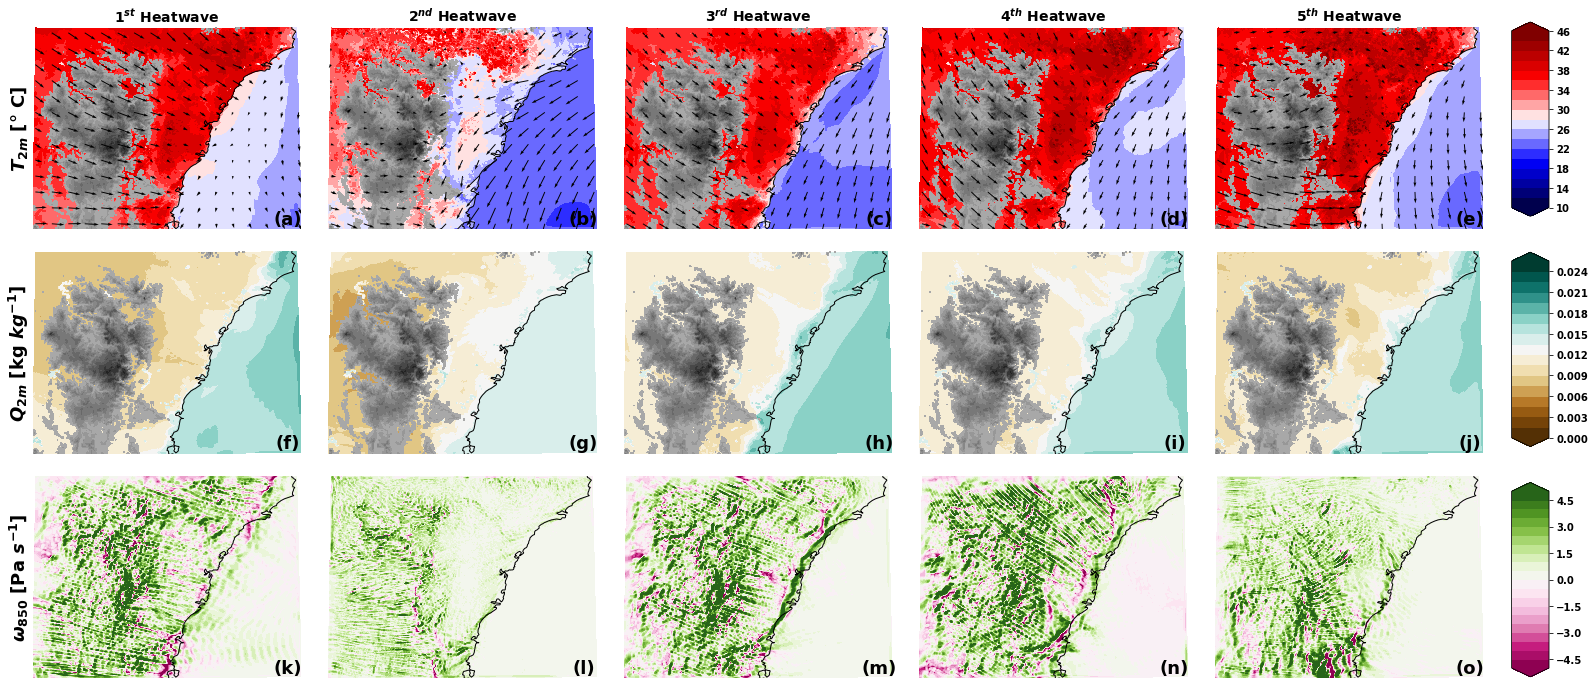

In [9]:
mx = [45.0,0.025,15.0,5.0,1010.]
mn = [10.0,0.0,0.0,-5.0,860.]
figurename = 'contour_heatwave_onset.png'
plot_contour(lat2d,lon2d,np.nanmean(t2,axis=1),np.nanmean(q2,axis=1),
             np.nanmean(wspd,axis=1),np.nanmean(psfc,axis=1),np.nanmean(u10,axis=1),np.nanmean(v10,axis=1),
             np.nanmean(o850,axis=1),hgt2d,figurename,mx,mn)


### Compare d02 and d03

In [10]:
t2d03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
q2d03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
psfcd03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
wspdd03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
u10d03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
v10d03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
o850d03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
u850d03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
v850d03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
w850d03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
divd03 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)

for hh in range(nhw):
    for mm in range(nmem):
        
        # Files list
        fileprefix = '%s/%s/WRF_output/%s/wrfout_%s_2017-' %(datadir,ensmem[mm],'d03','d03')
        filelist = sorted(glob.glob('%s%s_0[0-2]*' %(fileprefix,hwdates[hh])))

        wrffiles = [nc.Dataset(filelist[0]),nc.Dataset(filelist[1]),nc.Dataset(filelist[2])]
        
        t2tmp = wrf.getvar(wrffiles,'T2',timeidx=None,method='cat')[:,:,:] - 273.15 # to degC
        q2tmp = wrf.getvar(wrffiles,'Q2',timeidx=None,method='cat')[:,:,:]
        ptmp = wrf.getvar(wrffiles,'PSFC',timeidx=None,method='cat')[:,:,:] /100. # to hPa
        utmp = wrf.getvar(wrffiles,'U10',timeidx=None,method='cat')[:,:,:]
        vtmp = wrf.getvar(wrffiles,'V10',timeidx=None,method='cat')[:,:,:]
        wtmp  = wrf.getvar(wrffiles,"wspd_wdir10",timeidx=None,method='cat')[:,:,:,:] # 10m wind speed and direction
        
        t2d03[hh,mm,:,:] = np.nanmean(t2tmp,axis=0)
        q2d03[hh,mm,:,:] = np.nanmean(q2tmp,axis=0)
        psfcd03[hh,mm,:,:] = np.nanmean(ptmp,axis=0)
        u10d03[hh,mm,:,:] = np.nanmean(utmp,axis=0)
        v10d03[hh,mm,:,:] = np.nanmean(vtmp,axis=0)
        wspdd03[hh,mm,:,:] = np.nanmean(wtmp[0,:,:,:],axis=0)

        # Calculating the omega to evaluate vertical motion 
        pressure = wrf.getvar(wrffiles,"pressure",timeidx=None,method='cat')
        omega = wrf.getvar(wrffiles,"omega",timeidx=None,method='cat')
        omega850 = wrf.to_np(wrf.interplevel(omega,pressure,850.))
        o850d03[hh,mm,:,:] = np.nanmean(omega850,axis=0)
        
        for a in range(len(filelist)):
            wrffiles[a].close()
        
        del filelist,fileprefix,t2tmp,q2tmp,ptmp,utmp,vtmp,wtmp,pressure,omega,omega850
 

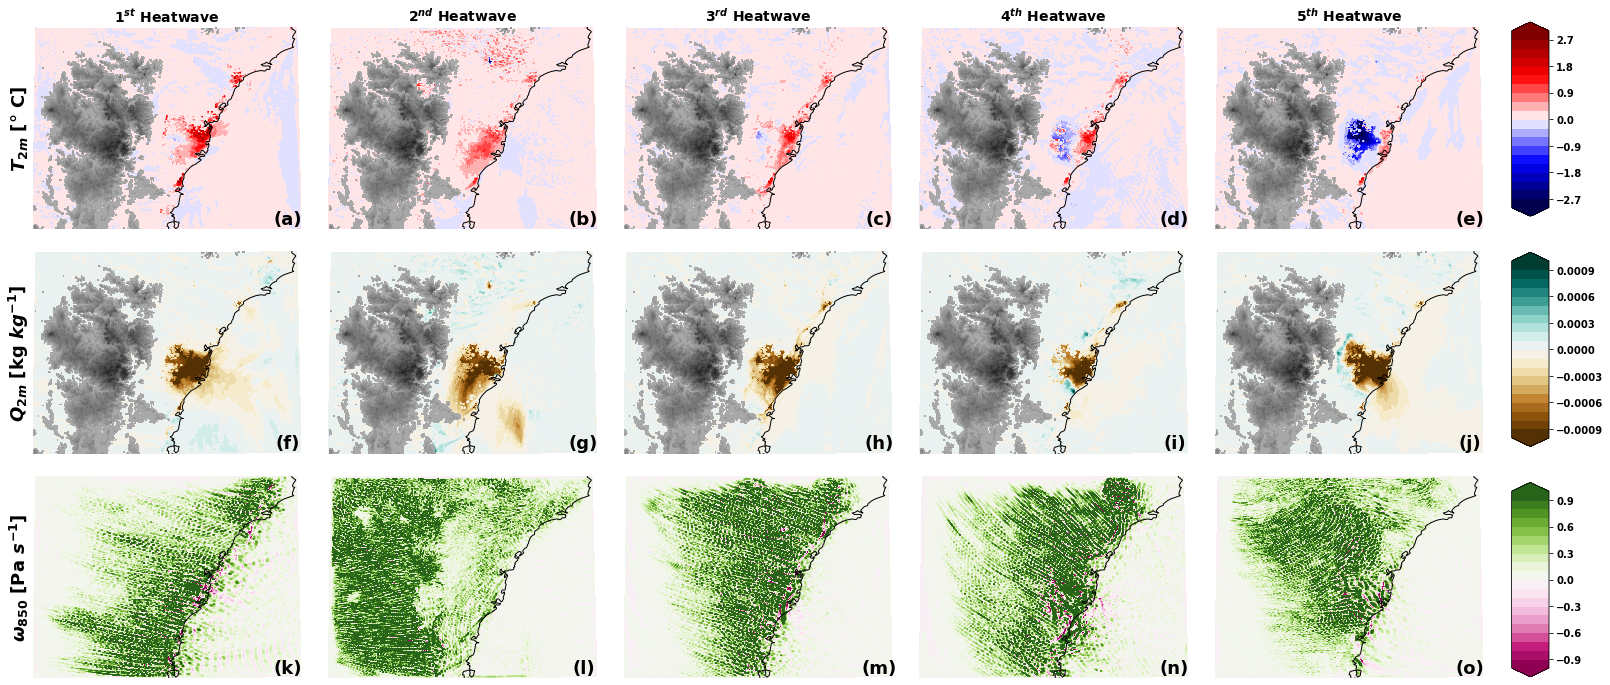

In [14]:
mx = [3.0,0.001,15.0,1.0,1010.]
mn = [-3.0,-0.001,0.0,-1.0,860.]
figurename = 'contour_heatwave_onset_d02-d03.png'

t2diff = (np.nanmean(t2,axis=1)-np.nanmean(t2d03,axis=1))
q2diff = (np.nanmean(q2,axis=1)-np.nanmean(q2d03,axis=1))
wspddiff = (np.nanmean(wspd,axis=1)-np.nanmean(wspdd03,axis=1))
psfcdiff = (np.nanmean(psfc,axis=1)-np.nanmean(psfcd03,axis=1))
u10diff = np.empty((nhw,nlat,nlon),dtype=np.float64)
u10diff[:,:,:] = np.nan
v10diff = np.empty((nhw,nlat,nlon),dtype=np.float64)
v10diff[:,:,:] = np.nan
o850diff = (np.nanmean(o850,axis=1)-np.nanmean(o850d03,axis=1))

plot_contour(lat2d,lon2d,t2diff,q2diff,wspddiff,psfcdiff,u10diff,v10diff,o850diff,hgt2d,figurename,mx,mn)


### Examine HW termination

In [ ]:
hwdates = ['01-14','01-18','02-01','02-07','02-12']
nhw = len(hwdates)
t2 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
q2 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
psfc = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
wspd = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
u10 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)
v10 = np.empty((nhw,nmem,nlat,nlon),dtype=np.float64)

for hh in range(nhw):
    for mm in range(nmem):
        
        # Files list
        fileprefix = '%s/%s/WRF_output/%s/wrfout_%s_2017-' %(datadir,ensmem[mm],domain[mm],domain[mm])
        filelist = sorted(glob.glob('%s%s_1[0-2]*' %(fileprefix,hwdates[hh])))

        wrffiles = [nc.Dataset(filelist[0]),nc.Dataset(filelist[1]),nc.Dataset(filelist[2])]
        
        t2tmp = wrf.getvar(wrffiles,'T2',timeidx=None,method='cat')[:,:,:] - 273.15 # to degC
        q2tmp = wrf.getvar(wrffiles,'Q2',timeidx=None,method='cat')[:,:,:]
        ptmp = wrf.getvar(wrffiles,'PSFC',timeidx=None,method='cat')[:,:,:] /100. # to hPa
        utmp = wrf.getvar(wrffiles,'U10',timeidx=None,method='cat')[:,:,:]
        vtmp = wrf.getvar(wrffiles,'V10',timeidx=None,method='cat')[:,:,:]
        wtmp  = wrf.getvar(wrffiles,"wspd_wdir10",timeidx=None,method='cat')[:,:,:,:] # 10m wind speed and direction

        t2[hh,mm,:,:] = np.nanmean(t2tmp,axis=0)
        q2[hh,mm,:,:] = np.nanmean(q2tmp,axis=0)
        psfc[hh,mm,:,:] = np.nanmean(ptmp,axis=0)
        u10[hh,mm,:,:] = np.nanmean(utmp,axis=0)
        v10[hh,mm,:,:] = np.nanmean(vtmp,axis=0)
        wspd[hh,mm,:,:] = np.nanmean(wtmp[0,:,:,:],axis=0)
        
        if hh == 0 and mm == 0:
            z = wrf.getvar(wrffiles,"z",timeidx=None,method='cat')[0,:,0,0]
        
        for a in range(len(filelist)):
            wrffiles[a].close()
        
        del filelist,fileprefix,t2tmp,q2tmp,ptmp,utmp,vtmp,wtmp
 

In [ ]:
mx = [45.0,0.025,15.0,1010.]
mn = [10.0,0.0,0.0,860.]
figurename = 'contour_heatwave_termination.png'
plot_contour(lat2d,lon2d,np.nanmean(t2,axis=1),np.nanmean(q2,axis=1),
             np.nanmean(wspd,axis=1),np.nanmean(psfc,axis=1),np.nanmean(u10,axis=1),np.nanmean(v10,axis=1),
             hgt2d,figurename,mx,mn)


### Plot contour for Foehn-like instances

In [ ]:
t2 = np.empty((5,nmem,nlat,nlon),dtype=np.float64)
q2 = np.empty((5,nmem,nlat,nlon),dtype=np.float64)
psfc = np.empty((5,nmem,nlat,nlon),dtype=np.float64)
wspd = np.empty((5,nmem,nlat,nlon),dtype=np.float64)
u10 = np.empty((5,nmem,nlat,nlon),dtype=np.float64)
v10 = np.empty((5,nmem,nlat,nlon),dtype=np.float64)

#hwdates = ['01-11_00:00','01-11_01:00','01-11_02:00','01-11_03:00','01-11_04:00']
hwdates = ['01-13_00','01-13_01','01-13_02','01-13_03','01-13_04']

for hh in range(5):
    for mm in range(nmem):
        
        # Files list
        fileprefix = '%s/%s/WRF_output/%s/wrfout_%s_2017-' %(datadir,ensmem[mm],domain[mm],domain[mm])
        print('%s%s*' %(fileprefix,hwdates[hh]))
        filelist = sorted(glob.glob('%s%s*' %(fileprefix,hwdates[hh])))

        wrffile = nc.Dataset(filelist[0])
        
        t2[hh,mm,:,:] = wrf.getvar(wrffile,'T2',timeidx=None,method='cat')[0,:,:] - 273.15 # to degC
        q2[hh,mm,:,:] = wrf.getvar(wrffile,'Q2',timeidx=None,method='cat')[0,:,:]
        psfc[hh,mm,:,:] = wrf.getvar(wrffile,'PSFC',timeidx=None,method='cat')[0,:,:] /100. # to hPa
        u10[hh,mm,:,:] = wrf.getvar(wrffile,'U10',timeidx=None,method='cat')[0,:,:]
        v10[hh,mm,:,:] = wrf.getvar(wrffile,'V10',timeidx=None,method='cat')[0,:,:]
        wspd[hh,mm,:,:]  = wrf.getvar(wrffile,"wspd_wdir10",timeidx=None,method='cat')[0,0,:,:] # 10m wind speed and direction

        if hh == 0 and mm == 0:
            z = wrf.getvar(wrffile,"z",timeidx=None,method='cat')[0,:,0,0]
        
        wrffile.close()
        
        del filelist,fileprefix
 

In [ ]:
mx = [45.0,0.025,15.0,1010.]
mn = [10.0,0.0,0.0,860.]
figurename = 'contour_heatwave_onset_HW1.png'
plot_contour(lat2d,lon2d,np.nanmean(t2,axis=1),np.nanmean(q2,axis=1),
             np.nanmean(wspd,axis=1),np.nanmean(psfc,axis=1),np.nanmean(u10,axis=1),np.nanmean(v10,axis=1),
             hgt2d,figurename,mx,mn)


In [ ]:
mx = [45.0,0.025,15.0,1010.]
mn = [10.0,0.0,0.0,860.]
figurename = 'contour_heatwave_secondTpeak_HW1.png'
plot_contour(lat2d,lon2d,np.nanmean(t2,axis=1),np.nanmean(q2,axis=1),
             np.nanmean(wspd,axis=1),np.nanmean(psfc,axis=1),np.nanmean(u10,axis=1),np.nanmean(v10,axis=1),
             hgt2d,figurename,mx,mn)


For the parent domain

In [ ]:
# Landsea mask
mask_file='/g/data/w97/azh561/WRF/sydney800m/geo_em.d01.nc'
f = nc.Dataset(mask_file)
lat2d = f.variables['XLAT_M'][0,:,:]
lontmp = f.variables['XLONG_M'][0,:,:]
lon2d = np.where(lontmp<0.0,lontmp+360,lontmp)
hgt2d = f.variables['HGT_M'][0,:,:]
lsmask = f.variables['LANDMASK'][0,:,:]
clon = f.getncattr('CEN_LON')
nlu = f.getncattr('NUM_LAND_CAT')
iswater = f.getncattr('ISWATER')
nlat,nlon = lon2d.shape
f.close()


In [ ]:
t2 = np.empty((5,nmem,nlat,nlon),dtype=np.float64)
q2 = np.empty((5,nmem,nlat,nlon),dtype=np.float64)
psfc = np.empty((5,nmem,nlat,nlon),dtype=np.float64)
wspd = np.empty((5,nmem,nlat,nlon),dtype=np.float64)
u10 = np.empty((5,nmem,nlat,nlon),dtype=np.float64)
v10 = np.empty((5,nmem,nlat,nlon),dtype=np.float64)

#hwdates = ['01-11_00:00','01-11_01:00','01-11_02:00','01-11_03:00','01-11_04:00']
hwdates = ['01-13_00:10','01-13_01:10','01-13_02:10','01-13_03:10','01-13_04:10']

for hh in range(5):
    for mm in range(nmem):
        
        # Files list
        fileprefix = '%s/%s/WRF_output/%s/wrfout_%s_2017-' %(datadir,ensmem[mm],'d01','d01')
        filelist = sorted(glob.glob('%s%s*' %(fileprefix,hwdates[hh])))

        wrffile = nc.Dataset(filelist[0])
        
        t2[hh,mm,:,:] = wrf.getvar(wrffile,'T2',timeidx=None,method='cat')[0,:,:] - 273.15 # to degC
        q2[hh,mm,:,:] = wrf.getvar(wrffile,'Q2',timeidx=None,method='cat')[0,:,:]
        psfc[hh,mm,:,:] = wrf.getvar(wrffile,'PSFC',timeidx=None,method='cat')[0,:,:] /100. # to hPa
        u10[hh,mm,:,:] = wrf.getvar(wrffile,'U10',timeidx=None,method='cat')[0,:,:]
        v10[hh,mm,:,:] = wrf.getvar(wrffile,'V10',timeidx=None,method='cat')[0,:,:]
        wspd[hh,mm,:,:]  = wrf.getvar(wrffile,"wspd_wdir10",timeidx=None,method='cat')[0,0,:,:] # 10m wind speed and direction

        if hh == 0 and mm == 0:
            z = wrf.getvar(wrffile,"z",timeidx=None,method='cat')[0,:,0,0]
        
        wrffile.close()
        
        del filelist,fileprefix
 